In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from transformers import BertTokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import io

c:\Users\theo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('./dataset/The_Office_lines.csv')
data = data.drop(columns= ['id', 'season', 'episode', 'scene', 'speaker', 'deleted'])

# Drop rows where 'Sentence' is NaN
data = data.dropna(subset=['line_text'])

sentences = data['line_text']
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
input_sequences = [tokenizer.encode(s, add_special_tokens=True) for s in sentences]

max_sequence_len = 25

x = [seq[:-1] for seq in input_sequences]
y = [seq[1:] for seq in input_sequences]

x = pad_sequences(x, maxlen=max_sequence_len - 1, padding='post', truncating='post')
y = pad_sequences(y, maxlen=max_sequence_len - 1, padding='post', truncating='post')

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=120)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=120)

In [3]:
# Positional encoding

def positional_encoding(position, d_model):
    angle_rads = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(position * angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(position * angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

print(positional_encoding(max_sequence_len, 128))

tf.Tensor(
[[[-0.13235176  0.99120283  0.3354101  -0.9420722  -0.10202286
    0.99478203 -0.5025774  -0.8645322   0.99691     0.0785528
   -0.3822061   0.9240771  -0.8990674  -0.4378103   0.29114625
   -0.95667857  0.9986632  -0.05168947  0.53361034  0.8457304
   -0.34735692  0.937733   -0.91250753  0.4090599  -0.96464837
   -0.26354033 -0.65048563 -0.75951856 -0.19102958 -0.9815843
    0.2518948  -0.9677546   0.5984721  -0.8011436   0.8286445
   -0.5597752   0.954165   -0.29928115  0.9986139  -0.05263342
    0.9864277   0.16419612  0.93820924  0.3460686   0.86952573
    0.4938876   0.79130185  0.61142564  0.7107539   0.7034407
    0.632367    0.77466893  0.5587215   0.82935536  0.49112543
    0.87108886  0.4300696   0.90279573  0.3755421   0.9268053
    0.32723913  0.9449416   0.28470194  0.9586161   0.24740396
    0.9689124   0.21480393  0.9766572   0.18637732  0.98247826
    0.16163322  0.9868509   0.1401227   0.9901341   0.12144138
    0.9925986   0.10522895  0.994448    0.09116677

In [4]:
# Scaled dot product attention

def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    d_k = tf.cast(tf.shape(key)[-1], tf.float32)

    scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [5]:
# Multi-Head Attention


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.num_depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)


    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.num_depth))
        return tf.transpose(x, perm=[0,2,1,3])


    def call(self, query, key, value, mask):
        batch_size = tf.shape(query)[0]

        query = self.split_heads(self.wq(query), batch_size)
        key = self.split_heads(self.wk(key), batch_size)
        value = self.split_heads(self.wv(value), batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

In [6]:
# Feed Forward

def point_wise_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [7]:
num_layers = 2
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = len(tokenizer.vocab)
maximum_position_encoding = max_sequence_len
dropout_rate = 0.3

inputs = tf.keras.layers.Input(shape=(max_sequence_len - 1,))

x = tf.keras.layers.Embedding(input_vocab_size, d_model)(inputs)
x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
x += positional_encoding(maximum_position_encoding, d_model)

x = tf.keras.layers.Dropout(dropout_rate)(x)

for _ in range(num_layers):
    attn_output, _ = MultiHeadAttention(d_model, num_heads)(x,x,x,None)
    x = tf.keras.layers.LayerNormalization(epsilon= 1e-6)(x + attn_output)
    ff_output = point_wise_forward_network(d_model, dff)(x)
    x = tf.keras.layers.LayerNormalization(epsilon= 1e-6)(x + ff_output)

outputs = tf.keras.layers.Dense(input_vocab_size, activation='softmax')(x)
transformer = tf.keras.Model(inputs=inputs, outputs=outputs)

transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transformer.summary()

epochs = 10
batch_size = 8

history = transformer.fit( 
                          x_train, 
                          np.expand_dims(y_train, -1),
                          validation_data=(x_val, np.expand_dims(y_val, -1)),
                          epochs=epochs,
                          batch_size=batch_size
                        )

loss, accuracy = transformer.evaluate(x_test, np.expand_dims(y_test, -1))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 24, 128)   │  3,711,488 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 24, 128)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 128)   │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 128)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, None,     │     66,048 │ dropout[0][0],    │
│ (MultiHeadAttentio… │ 128), (None, 8,   │            │ dropout[0][0],    │
│                     │ None, None)]      │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 24, 128)   │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 128)   │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 24, 128)   │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 24, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ [(None, None,     │     66,048 │ layer_normalizat… │
│ (MultiHeadAttentio… │ 128), (None, 8,   │            │ layer_normalizat… │
│                     │ None, None)]      │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 24, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 24, 128)   │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 128)   │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 7,848,516 (29.94 MB)

 Trainable params: 7,848,516 (29.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 812s 134ms/step - accuracy: 0.6161 - loss: 2.6342 - val_accuracy: 0.7226 - val_loss: 1.5443
Epoch 2/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 803s 134ms/step - accuracy: 0.7323 - loss: 1.3804 - val_accuracy: 0.7450 - val_loss: 1.3065
Epoch 3/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 801s 134ms/step - accuracy: 0.7557 - loss: 1.0919 - val_accuracy: 0.7506 - val_loss: 1.2365
Epoch 4/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 801s 134ms/step - accuracy: 0.7686 - loss: 0.9395 - val_accuracy: 0.7538 - val_loss: 1.2046
Epoch 5/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 763s 127ms/step - accuracy: 0.7790 - loss: 0.8463 - val_accuracy: 0.7575 - val_loss: 1.1900
Epoch 6/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 753s 126ms/step - accuracy: 0.7842 - loss: 0.7977 - val_accuracy: 0.7564 - val_loss: 1.2231
Epoch 7/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 754s 126ms/step - accuracy: 0.7927 - loss: 0.7484 - val_accuracy: 0.7544 - val_loss: 1.2539
Epoch 8/10
5991/5991 ━━━━━━━━━━━━━━━━━━━━ 755s 126ms/step - ac

188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.7510 - loss: 1.3217
Test Loss:  1.3223029375076294
Test Accuracy:  0.7501668930053711


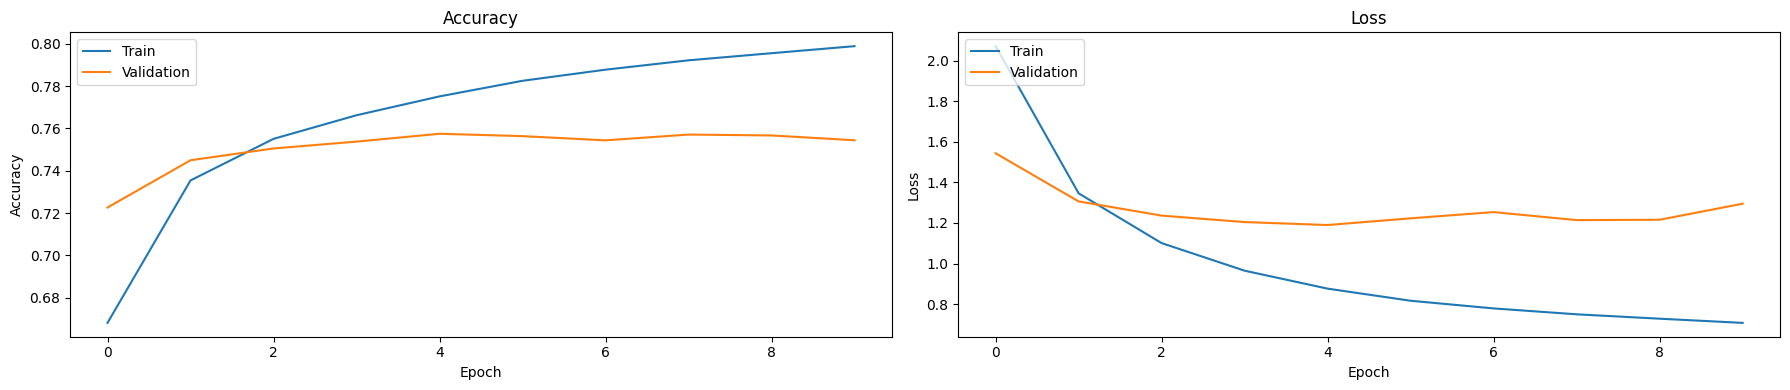

In [8]:
# Evaluate the model
loss, accuracy = transformer.evaluate(x_test, np.expand_dims(y_test, -1))

print('Test Loss: ', loss)
print('Test Accuracy: ', accuracy)

# Plotting
plt.figure(figsize=(18, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('Self Supervised Learning Accuracy and Loss Graph.png')
plt.show()


In [9]:
# Predict token

def predict_next_token(model, tokenizer, text):
    encoded_input = tokenizer.encode(text, add_special_tokens=True)
    padded_input = pad_sequences([encoded_input], maxlen=max_sequence_len - 1, padding='post', truncating='post')
    prediction = model.predict(padded_input)
    last_token_prediction = prediction[0, -1, :]
    predicted_index = np.argmax(last_token_prediction)

    return tokenizer.decode([predicted_index])


sentence = "Syrio says every hurt is a lesson and every lesson makes you better. Tomorrow I'm going to be chasing cats"

predicted_token = predict_next_token(transformer, tokenizer, sentence)

print('Predicted Token : ', predicted_token)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Predicted Token :  decent
